<a href="https://colab.research.google.com/github/alexvaroz/data_science_alem_do_basico/blob/master/Previsao_Precos_Imoveis_California.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

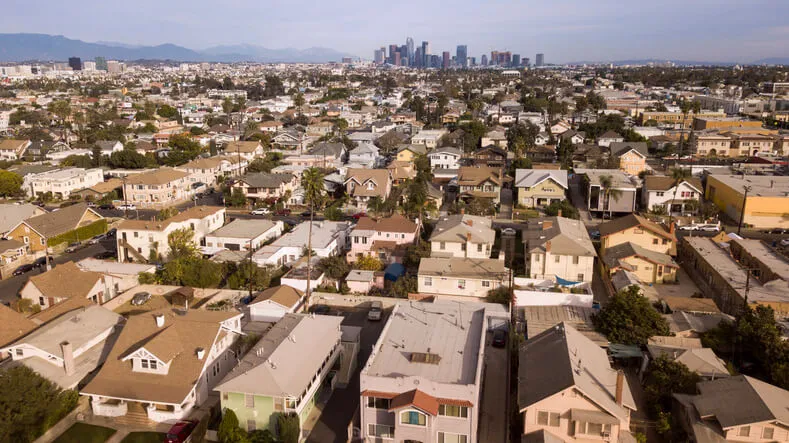

Este notebook tem o objetivo de apresentar a criação um modelo de regressão baseado no capítulo 2 do **ótimo** livro ***Mãos a obra: Aprendizado de Máquina com Scikit-Learn, Keras e TensorFlow*** de Aurélien Géron.

A atividade traz um valor interessante por entregar um passo-a-passo da criação do modelo desde a obtenção dos dados, até a validação do modelo. Sempre que possível, são destacadas as melhores práticas em cada um dos passos.

O modelo se propõe a prever preço médio de um imóvel de uma determinada região do estado da Califórnia, baseando-se em dados históricos. 

O conjunto de dados está disponível em https://github.com/ageron/handson-ml/blob/master/datasets/housing/housing.tgz

Para contextualizar, trata-se de um dataset baseado no censo da Califórnia de 1990. Cada registro refere-se a dados de uma **região** do estado. Cada região é composta por um conjunto de bairros e comporta uma população de 600 a 3 mil pessoas.

Uma versão desse dataset é disponibilizado no próprio `Colab` na pasta `sample_data`. Entretanto, será utilizada a versão adotada no livro para possibilitar uma abordagem mais completa de todo o processo de criação de um modelo preditivo. 


In [1]:
# Importação das bibliotecas
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import gzip


## **1. Obtenção dos dados**

Os dados serão obtidos via download diretamente do repositório e armazenados em uma pasta específica. Como o plano original é executar este notebook no ambiente do Colab, essa pasta será criada no sistema de arquivos da máquina virtual, implicando dizer que ela não é aproveitada em uma execução posterior do notebook, fato que seria diferente se houvesse a utilização do Drive pessoal, no qual a pasta seria persistida de forma permanente.

Se o notebook for executado em um ambiente local, a pasta será criada no mesmo diretório onde o notebook está sendo executado.

Para essa etapa serão criadas funções para realizarem as etapas de obtenção e carga dos dados em um dataframe Pandas.

***A utilização de funções é muito importante para possibilitar uma automação do processo de obtenção e tratamento dos dados e, consequentemente, geração do modelo***

In [2]:
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
DATASET_PATH = "/content/dataset_housing"

# Função para obtenção dos dados
def fetch_housing_data(download_url=DOWNLOAD_URL, dataset_path=DATASET_PATH):
    os.makedirs(dataset_path, exist_ok=True) # cria o diretório
    tgz_path = os.path.join(dataset_path, "housing.tgz")
    urllib.request.urlretrieve(download_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=dataset_path)
    housing_tgz.close()

# Função para carregar os dados em um dataframe pandas
def load_housing_data(dataset_path=DATASET_PATH):
    csv_path = os.path.join(dataset_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing_total = load_housing_data()
housing_total.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Com o comando `describe()` é possível dar uma visualizada geral nas estatísticas dos atributos numéricos (quase todos) com o fito de verificar a distribuição dos valores e escala de cada atributo.

In [4]:
housing_total.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Do resultado apresentado, verifica-se que o único atributo que não apresenta todos os valores presentes é o `tota_bedroms`. **Essa informação será utilizada mais adiante, quando será tratada a estratégia para lidar com dados faltantes.**

A variável a ser predita (variável dependente ou variável a ser explicada) será o **valor médio do imóvel** (`median_house_value`). 

Os atributos listados de cada imóvel são:
* `latitude` e `longitude` : coordenadas geográficas da região;
* `housing_median_age`: idade média dos imóveis da região;
* `total_rooms`: total de cômodos dos imóveis da região;
* `total_bedrooms`: total de quartos dos imóveis da região;
* `population`: tamanho da população que vive na região;
* `households`: quantidade de famílias que vivem na região;
* `median_income`: renda média das pessoas que vivem na região;
* `ocean_proximity`: proximidade da região com o oceano (única variável categórica).

Ainda nessa fase inicial do trabalho, é interessante separar uma parte dos dados para o chamado **teste de generalização**, que seria a verificação de que o modelo gerado funciona de forma equivalente no treinamento e com dados com os quais nunca teve contato.

A boa prática é separar 20% da base, de forma aleatória. A biblioteca `Scikit-Learn` possui uma função específica para essa tarefa.
A definição de uma semente (`random_state`), é apropriada para que os dados de teste sempre sejam os mesmos.

In [5]:
from sklearn.model_selection import train_test_split

housing_train, housing_test = train_test_split(housing_total, test_size=0.2, random_state=42)
print("Dados de treinamento" , housing_train.shape)
print("Dados de teste" , housing_test.shape)

Dados de treinamento (16512, 10)
Dados de teste (4128, 10)


Daqui para frente, o conjunto a ser trabalhado é a parcela dedicada ao treinamento do modelo. A parcela restante, será utilizada somente ao final do processo.

**Uma boa prática é fazer uma cópia dos dados a serem trabalhados para manter uma fonte que não foi alterada.** 

In [6]:
housing = housing_train.copy()

## **2. Análise exploratória sobre os dados**

Nessa etapa os dados serão explorados para conhecê-los melhor.

#### **Verificando a distribuição dos valores**

Um primeiro passo para explorar um dataset é verificar a distribuição dos valores de cada atributo. Essa informação pode ser obtida de forma visual com gráficos de histograma, que refletem a frequência de cada valor de atributo.

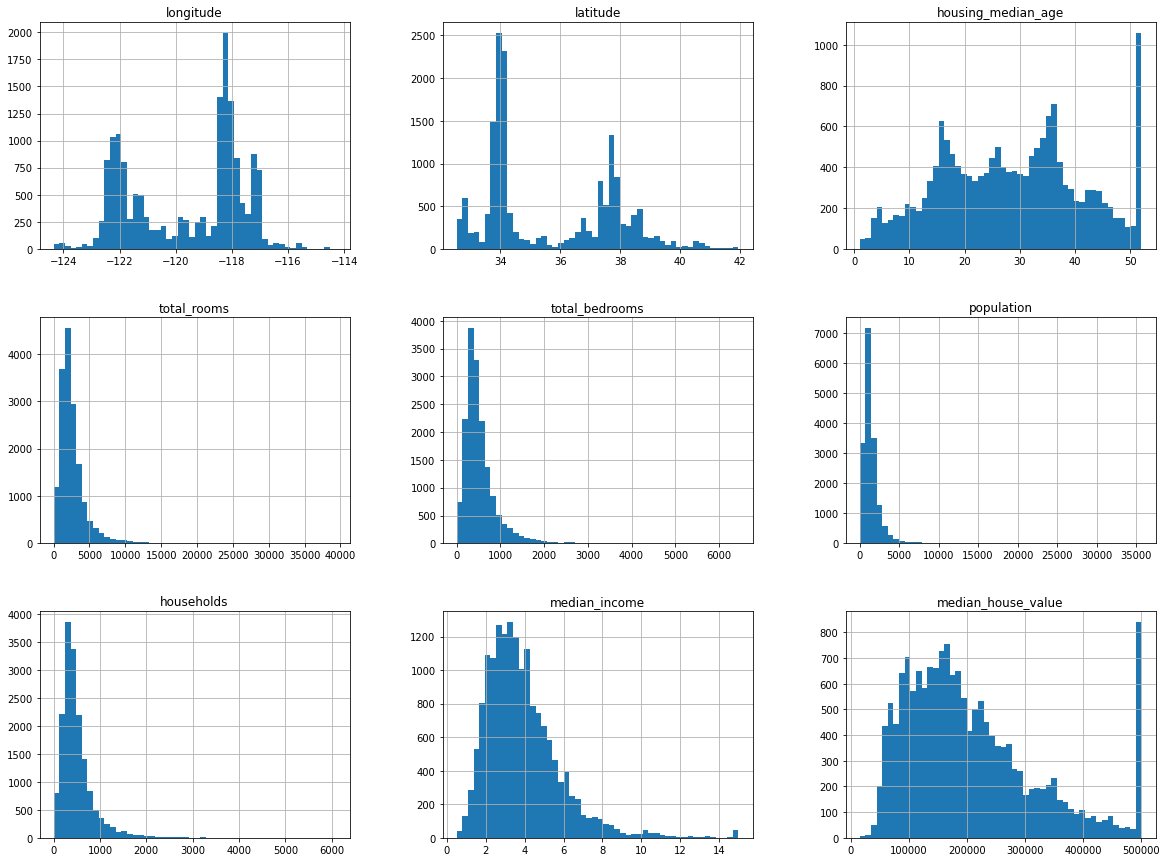

In [7]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Os histogramas plotados nos oferecem algumas informações importantes que deverão ser levadas em consideração no desenvolvimento do modelo.

*   Os atributos `housing_median_age` e `median_house_value` possuem uma concentração muito alta nos valores extremos, indicando que tenha sido imposto um limite para os dados. Por exemplo, nenhuma residência poderia custar mais que US$ 500 mil, fato com potencial de atrapalhar o modelo peditivo, visto que se trata, justamente, da variável a ser predita.

*   O atributo `median_income` está expresso em uma unidade diferente do que se esperaria (em dólares), indicando que ocorreu um pré-tratamento nos dados. Essa informação é importante para ser levada em conta quando o modelo for colocado em produção.

* Outro ponto a ser levado em consideração é a diferença entre as escalas, fato que orientará um tratamento específico a ser realizado mais à frente.

##### **Visualisando os dados geográficos**

Como o dataset apresenta as coordenadas geográficas (latitude e longitude) de cada região, uma boa idéa é criar um diagrama de dispersão para visualizar algum padrão existente.

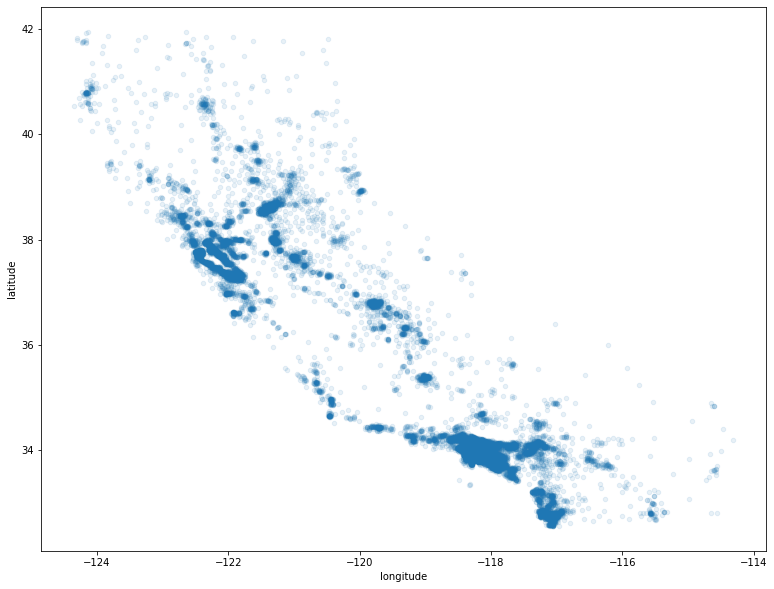

In [8]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(13,10))

Analisando-se o mapa real, verifica-se que as áreas mais densas, com maior quantidade de registros, estão localizadas nas proximidades de São Francisco e Los Angeles, conforme o esperado.

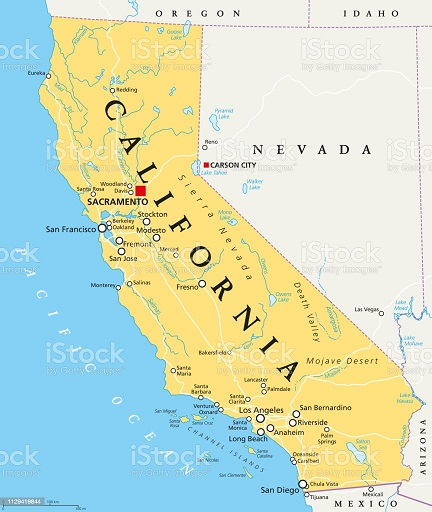

Uma possibilidade é apresentar no mapa as informações sobre o preço médio de cada região (cor) e a população (diâmetro do círculo).

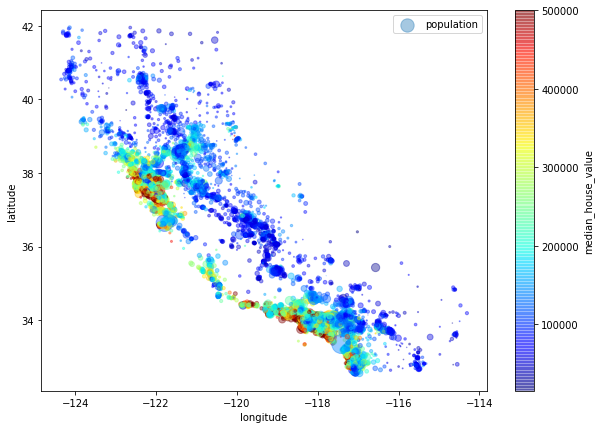

In [9]:
# Relacionando os preços dos imóveis e localização
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Essa informação confirma o que já era esperado, ou seja, o preço apresenta uma correlação com a localização e densidade populacional. Na próxima etapa serão buscadas mais informações sobre correlações entre os demais atributos.

#### **Buscando correlações**

A tarefa agora é identificar as correlações entre os atributos. Para isso será utilizado o coeficiente de correlação de Pearson.

In [10]:
# Coeficiente de correlação de Pearson(chamado de correlação padrão)
corr_matrix=housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924485,-0.101818,0.038676,0.063064,0.094276,0.049306,-0.017040,-0.046349
latitude,-0.924485,1.000000,0.005296,-0.029224,-0.059998,-0.102499,-0.064061,-0.076571,-0.142983
housing_median_age,-0.101818,0.005296,1.000000,-0.360922,-0.320624,-0.292283,-0.302796,-0.121711,0.103706
total_rooms,0.038676,-0.029224,-0.360922,1.000000,0.930489,0.857936,0.920482,0.198268,0.133989
total_bedrooms,0.063064,-0.059998,-0.320624,0.930489,1.000000,0.878932,0.980255,-0.009141,0.047980
population,0.094276,-0.102499,-0.292283,0.857936,0.878932,1.000000,0.907452,0.004122,-0.026032
households,0.049306,-0.064061,-0.302796,0.920482,0.980255,0.907452,1.000000,0.012776,0.063714
median_income,-0.017040,-0.076571,-0.121711,0.198268,-0.009141,0.004122,0.012776,1.000000,0.690647
median_house_value,-0.046349,-0.142983,0.103706,0.133989,0.047980,-0.026032,0.063714,0.690647,1.000000


O coeficiente de correlação varia de -1 a 1. Quando está próximo de 1 , significa que existe uma forte correlação positiva. O que pode ser verificado na relação entre a quantidade de famílias (`households`) e o tamanho da população (`population`), ou seja, quando maior o número de famílias, maior tende a população. Por outro lado, quando está próximo de -1, significa que existe uma forte correlação negativa. Um exemplo de correlação negativa pode ser encontrado entre os atributos número total de quartos (`total_rooms`) e a idade média dos imóveis (`housing_median_age`), implicando inferir que quanto mais antigo o imóvel, menor o número de quartos.

Como a variável a ser predita é o valor médio da casa (`median_house_value`) vamos separar as correlações referentes a ela de forma ordenada.

In [11]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

Com base no resultado obtido, verifica-se que o atributo que mais se correlaciona com o valor médio da residência é a renda média da população da região. 
Como forma de investigar melhor essa correlação, pode-se plotar a relação entre `median_income` e `median_house_value`, para verificar que a reta que poderia representar essa relação, possui uma inclinação positiva.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f11ef7890>,
      dtype=object)

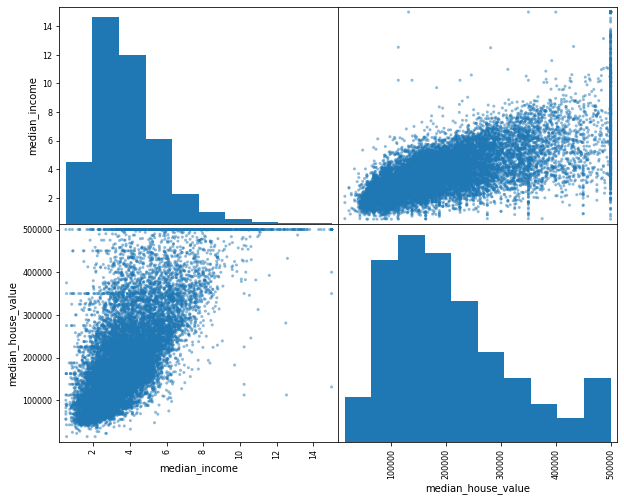

In [12]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing[['median_income','median_house_value']], figsize=(10,8))

Muitas vezes é interessante verificar esses gráficos com todos os atributos numéricos.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f11ab6610>,
      dtype=object)

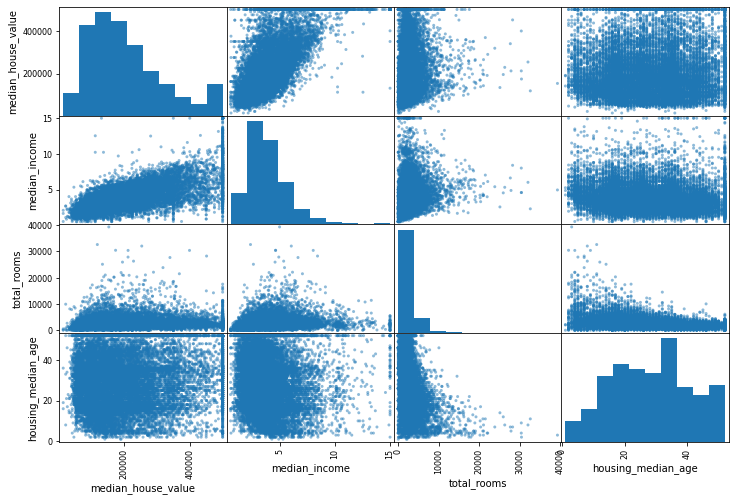

In [13]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

No campo da análise da correlação dos atributos, podem ser testadas combinações deles que resultem em uma eventual correlação mais interessante. Fato que poderia justificar a inclusão desse novo atributo no modelo.

Por exemplo: 
* *total de cômodos por quantidade de famílias;*
* *total de quartos por quantidade de cômodos;*
* *população por quantidade de famílias.*

Vamos criar essas composições e verificar se possuem correlação maior.

In [14]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [15]:
# Verificando a correlação dos atributos criados
housing.corr().median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

Os novos atributos se mostraram com taxas de correlação maiores ou bem próximas que os originais.
A decisão será por manter os novos atributos.

Finalizada a etapa de exploração, chegou a hora de preparar os dados para o modelo.

##**3. Preparação dos dados para a criação dos modelos**



A primeira etapa da preparação é separar os valores a serem preditos do conjunto de treinamento, no caso, separar atributo `median_house_value`:

In [16]:
housing_labels = housing_train['median_house_value'].copy()
housing = housing_train.drop('median_house_value', axis = 1) # retirada da variável a ser predita do restante.

**Detalhe para a utilização do conjunto de treinamento original.**

No ínício da análise, foi registrado que o atributo `total_bedrooms` seria o único com valores faltantes, o que indicaria a necessidade de estabelecer um tratamento adequado.

Dentre as 3 abordagens possíveis no tratamento de dados faltantes: *(i) Eliminar os registros, (ii) Eliminar o atributo, (iii) Preencher com um valor calculado*, será seguida a terceira opção.

A heurística para esse preenchimento pode ser a média dos demais valores do dataset, ou ainda outro cálculo considerando outros atributos. No caso, será ecolhido preencher os valores faltantes com a média dos demais. Daí, será utilizada uma facilidade da biblioteca ScikitLearn, o estimador `SimpleImpute` que verifica todos os atributos numéricos de um dataset e preenche os que estiverem faltando, de acordo com a estratégia adotada. 

Essa abordagem garante que dados futuros que possuam valores sem preenchimento sejam tratados automaticamente. A única restrição de utilizar o `SimpleImpute` é que não pode ser utilizado com atributos categóricos, mas somente numéricos. 

In [17]:
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+

imputer = SimpleImputer(strategy="mean") # conforme comentado, será adotada a estratégia de preencher com a média

In [18]:
# Eliminando a coluna categórica para o tratamento
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer()

Na célula abaixo então presentes os valores médios de cada atributo numérico.

In [19]:
imputer.statistics_

array([-119.58229046,   35.64314922,   28.60828488, 2642.0047844 ,
        538.49685078, 1426.45300388,  499.9869186 ,    3.88075426])

Os valores médios serão inseridos onde houver falta de dados.

In [20]:
# Chamada do método "transform" do estimador
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542
...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192


####**Tratamento de dados categóricos**

Voltemos a atenção para o atributo categórico `ocean_proximity`.

O primeiro passo é a verificação dos valores presentes.



In [21]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7341
INLAND        5227
NEAR OCEAN    2086
NEAR BAY      1854
ISLAND           4
Name: ocean_proximity, dtype: int64

Como a maioria dos algoritmos de machine learning prefere trabalhar com atributos númericos, a saída será transformar essas categorias em números.

Dada a característica do atributo não ser ordinal, ou seja, sem uma gradação clara, a saída é a utilizar a codificação `one-hot`, na qual é criado um atributo binário para cada categoria. Essa funcionalidade está disponível na `OneHotEncoder` do Scikit-Learn

In [22]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing[['ocean_proximity']])
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Para verificar as categorias transformadas, usa-se a variável `categories_`

In [23]:
cat_encoder.categories_[0]

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [24]:
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [25]:
pd.DataFrame(housing_cat_1hot, columns =cat_encoder.categories_[0] )

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
16507,1.0,0.0,0.0,0.0,0.0
16508,0.0,1.0,0.0,0.0,0.0
16509,1.0,0.0,0.0,0.0,0.0
16510,1.0,0.0,0.0,0.0,0.0


#### **Normalização dos atributos**

O comportamento dos algoritmos pode ser afetado pela diferença de **escala** entre os atributos numéricos.

Por exemplo:
* Número total de cômodos [6 e 39320]
* Renda média [0 a 15] 

São possíveis pelo menos duas abordagens: *normalização* e *padronização*.

Na normalização os valores são deslocados e reescalonados de modo que acabem variando de 0 a 1. Na Scikit-Learn é método `MinMaxScaler`, que, inclusive, comporta o hiperparâmetro `feature_range` que permite alterar o intervalo, caso não seja desejável usar o padrão 0-1, mas um outro, por exemplo 0-10.

Na padronização, não ocorre a vinculação a um intervalo especificado, mas sim uma distribuição dos valores no qual a média deve ser zero. Importante destacar que a padronização não é tão afetada por outliers. Na Scikit-Learn o transformador `StandardScaler` fornece essa funcionalidade.

No presente caso, todos os atributos numéricos serão transformados utilizando a estratégia de *padronização*. **Importante destacar que a variável a ser predita, não deve ser transformada.**

In [26]:
# Utilização do StandartScale

from sklearn.preprocessing import StandardScaler
data = housing_num
scaler = StandardScaler()
scaler.fit(data)
scaler.mean_

array([-119.58229046,   35.64314922,   28.60828488, 2642.0047844 ,
        538.49685078, 1426.45300388,  499.9869186 ,    3.88075426])

Na próxima etapa as transformações listadas serão acomodadas sequencialmente em um **pipeline**, possibilitando que o modelo seja gerado de forma que possibilite uma automação do processo, se for o caso.

#### **Transformação de Pipelines**

A classe Pipeline da ScikitLearn agrega as etapas de transformação, executando-as na ordem correta.

Até o momento, foram implementados o **estimador** referente ao preenchimento de valores faltantes (`SimpleImputer`), e os **transformadores** referentes ao tratamento dos dados categóricos (`OneHotEncoder`) e à normalização dos atributos (`StandardScaler`).

Ainda falta a etapa de criação dos atributos combinados (`rooms_per_household`,`bedrooms_per_room` e `population_per_household`). Este último transformador será implementado de forma customizada criando-se a classe a partir da herança das superclasses `BaseEstimator` e `TransformerMixin`.

Detalhe que a classe `BaseEstimator` será utilizada como superclasse devido à necessidade de se flexibilizar a escolha dos atributos que serão criados. Um hiperparâmetro será utilizado para definir quais atributos serão criados e adicionados.

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# pegando os índices das colunas que serão utilizadas
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

# O transformador customizado deve herdar das classes BaseEstimator e TransformerMixin
# São adicionados hiperparâmetros no construtor para indicar se o novo atributo 
# será adotado ou não
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True, 
                 add_rooms_per_household = True,
                 add_population_per_household = True,): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.add_rooms_per_household = add_rooms_per_household
        self.add_population_per_household = add_population_per_household

    def fit(self, X, y=None):
        return self  # não precisa fazer nada

    def transform(self, X, y=None):
        result = X
        if self.add_rooms_per_household:
          rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
          result = np.c_[result, rooms_per_household]
        if self.add_population_per_household:
          population_per_household = X[:, population_ix] / X[:, household_ix]
          result = np.c_[result, rooms_per_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            result = np.c_[result, bedrooms_per_room]
        return result

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

Dessa forma, está criado o último transformador necessário para a preparação do dataset para a criação do modelo preditivo.

Agora, segue a concatenação desses elementos em um **pipeline**.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Transformações sobre os atributos numéricos
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])

housing_num_tr = num_pipeline.fit_transform(housing_num)


O detalhe é que foi criado um pipeline específico para os atributos numéricos.

O atributo categórico necessita de um outro pipeline restrito. Entretanto, o módulo `ColumnTransformer` tem a capacidade de integrar pipelines categóricos e numéricos, resultando em somente 1 pipeline de pré-processamento que recebe os dados completos dos imóveis e aplica as transformações adequadas a cada coluna.

In [29]:
from sklearn.compose import ColumnTransformer

num_atribs = list(housing_num)
cat_atribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_atribs),
    ("cat", OneHotEncoder(), cat_atribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

## **4. Treinamento do modelo**

Finalmente chegou o momento de escolher e treinar o modelo. Para isso será utilizado inicialmente o algoritmo `LinearRegression`.

Para o treinamento e avaliação, será adotada a validação cruzada utilizando o método *k-fold* disponível na Scikit-Learn.

Outro ponto a ser definido é a métrica de erro a ser utilizada para verificação da qualidade do modelo. Comumente são adotadas as seguntes métricas para modelos de regressão:
* Mean Squared Error (MSE);
* Root Mean Squared Error (RMSE)
* Mean Absolute Error (MAE)

Neste modelo, será adotada a RMSE, entretanto, como o método de validação cruzada utilizado não implementa esse tipo de métrica, mas sim o MSE. Portanto, ao final, deverá ser calculada a raiz quadrada para a obtenção da métrica desejada.


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = LinearRegression()
scoring = 'neg_mean_squared_error'

scores = cross_val_score(model,housing_prepared, housing_labels, scoring=scoring, cv=10 )

rmse_scores = np.sqrt(-scores)

In [31]:
def resultado_avaliacao(rmse_scores, housing_labels):
  print("RMSE médio:", rmse_scores.mean())
  print("RMSE médio/Preço médio: ",rmse_scores.mean()/ housing_labels.mean())

In [32]:
resultado_avaliacao(rmse_scores, housing_labels)

RMSE médio: 67783.35984166704
RMSE médio/Preço médio:  0.32714814563454325


Ou seja, o erro médio da primeira tentativa de modelo foi por volta de U\$ 67783. O que representa cerca de 32% do valor médio de um imóvel.

Seguindo a estratégia, outro algoritmo será considerado, o `DecisionTreeRegressor`:

In [33]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
scores = cross_val_score(model,housing_prepared, housing_labels, scoring=scoring, cv=10 )

rmse_scores = np.sqrt(-scores)
resultado_avaliacao(rmse_scores, housing_labels)

RMSE médio: 69696.69298640684
RMSE médio/Preço médio:  0.3363826154475601


O resultado foi um erro maior do que o obtido no modelo `LinearRegression`.

Um próximo modelo será o `RandomForestRegressor`, que se caracteriza por acumular o treinamento de várias árvores de decisão chegando a resultados, frequentemente, mais interessantes do que uma única árvore.

In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
scores = cross_val_score(model,housing_prepared, housing_labels, scoring=scoring, cv=10 )

rmse_scores = np.sqrt(-scores)
resultado_avaliacao(rmse_scores, housing_labels)

RMSE médio: 49426.52780132329
RMSE médio/Preço médio:  0.23855112749098922


In [35]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

O resultado melhorou, ou seja, o erro diminuiu.

Outro modelo a ser testado será o `Support Vector Machine`. 

In [36]:
from sklearn.svm import SVR

model = SVR()
scores = cross_val_score(model,housing_prepared, housing_labels, scoring=scoring, cv=10)

rmse_scores = np.sqrt(-scores)
resultado_avaliacao(rmse_scores, housing_labels)


RMSE médio: 118444.42350804308
RMSE médio/Preço médio:  0.5716576103917103


O resultado piorou muito com esse modelo. Portanto, o mais adequado é trabalhar com o `RandomForestRegressor` buscando aperfeiçoá-lo com ajustes nos hiperparâmetros que tragam o melhor resultado.

## **5. Aperfeiçoamento do modelo**

Com a obtenção de um algoritmo candidato a ser utilizado para a concepção do modelo, chega o momento de aperfeiçoar os hiperparâmetros.

A ScikitLearn oferece a funcionalidade `GridSearchCV` que automatiza a busca pelos hiperparâmetros que seriam adequados para o melhor resultado.

Abaixo, os hiperparâmetros utilizados como padrão.

`class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)`

No caso, tentaremos buscar o melhor ajuste para os parâmetros `bootstrap` e `n_estimators` testando todas as combinações indicadas.

***Alerta para a duração de 30 minutos.***




In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'bootstrap': [True, False],'n_estimators':[10, 100, 120, 125], 'max_features':[ 6, 8, 10]},
]

model = RandomForestRegressor()

grid_search = GridSearchCV(model, param_grid, cv=8, scoring=scoring,
                           return_train_score=True)

In [38]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=8, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [6, 8, 10],
                          'n_estimators': [10, 100, 120, 125]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [39]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=8, n_estimators=120)

In [40]:
np.sqrt(-grid_search.best_score_)

48705.91902373425

O melhor modelo obteve o RMSE de cerca de U\$ 48.667, pouco melhor do que a versão que utiliza os parâmetros default.


## **6. Avaliando com o conjunto de testes**

Como forma de testar o modelo com dados ainda não utilizados, chega a hora do conjunto de dados separado no início do processo. 

Esses registros serão submetidos ao modelo implementado e verificado o erro. Esse procedimento pode identificar se o modelo está acoplado aos dados de treino e não consegue generalizar o comportamento para dados inéditos.

In [41]:
from sklearn.metrics import mean_squared_error

final_model = grid_search.best_estimator_
X_test = housing_test.drop("median_house_value", axis=1)
Y_test = housing_test["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(Y_test, final_predictions))
final_rmse

49030.63882409614

Como o erro foi bem próximo ao alcançado no treinamento, pode-se entender que o modelo não está sofrendo `overfitting`, situação na qual o modelo "decora" os dados. 

## **7. Conclusão**

Dessa forma, foi criado um modelo que realiza a previsão do preço médio de residências localizadas em cada região da Califórnia. O melhor resultado obtido alcançou um erro médio de cerca de U\$ 48667, o que corresponde a cerca de 23% do valor médio dos imóveis. 

O resultado final foi obtido após as etapas de carga, análise exploratória e preparação dos dados, que anteciparam o treinamento, aperfeiçoamento e avaliação do modelo.

Um benefício indireto do modelo é a obtenção da informação do grau de influência de cada atributo, que poderia direcionar decisões sobre qual atributo considerar no caso de haver opções entre qual considerar em uma eventual negociação.